# App Review Analysis using Open AI API


## Introduction

This Jupyter notebook is an atempt to use LLMs for Topic mining and google app review analysis. 


## Setup

This notebook was created using [Python version] and the following packages:

- google_play_scraper
- pandas
- numpy
- openai
- json
- os

To run this notebook, please make sure you have these packages installed.

## Author

Art Kreimer   
[LinkedIn](https://www.linkedin.com/in/artkreimer/)  
[Personal Blog](https://www.artkreimer.com/)  


In [1]:
import pandas as pd
import numpy as np
import json
import os
import openai
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS





In [2]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [4]:
# First lets use the scraper to get all Google App reviews
#
#--------------------
from google_play_scraper import app,Sort, reviews_all
path='~/Downloads'
df_reviews_file = path+'/app_reviews_data_02052023.csv'
if os.path.exists(df_reviews_file):
    df_reviews=pd.read_csv(df_reviews_file)
else:

    all_reviews = reviews_all(
        'ca.tangerine.clients.banking.app',
        sleep_milliseconds=0, # defaults to 0
        lang='en', # defaults to 'en'
        country='ca', # defaults to 'us'
        sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    )
    df_reviews = pd.DataFrame(np.array(all_reviews),columns=['review'])
    df_reviews = df_reviews.join(pd.DataFrame(df_reviews.pop('review').tolist()))
    df_reviews['at'] = df_reviews['at'].astype(str)
    df_reviews.head()


In [5]:
# let's take last 100 app reviews with rating below 4 stars
df_reviews['date']=df_reviews['at'].astype(str).str.split(' ')
df_reviews['date'].head()
df_reviews[['date','time']]=df_reviews['at'].astype(str).str.split(' ', expand=True)
df_reviews['date'] = pd.to_datetime(df_reviews['date'], format='%Y-%m-%d')
df_reviews['year'] = df_reviews['date'].dt.year
df_reviews['month'] = df_reviews['date'].dt.month
df_reviews['yearmonth'] = df_reviews['year'].astype(str) + df_reviews['month'].astype(str)
df_reviews['repliedbool']=df_reviews['repliedAt'].astype(str)!="NaT"

score          
           count      mean
year month                
2018 8       147  2.435374
     9        81  2.345679
     10       54  2.240741
     11       36  2.472222
     12       60  2.033333
...          ...       ...
2023 10       43  2.837209
     11       35  3.342857
     12       45  3.511111
2024 1        54  3.407407
     2        71  3.535211

[67 rows x 2 columns]

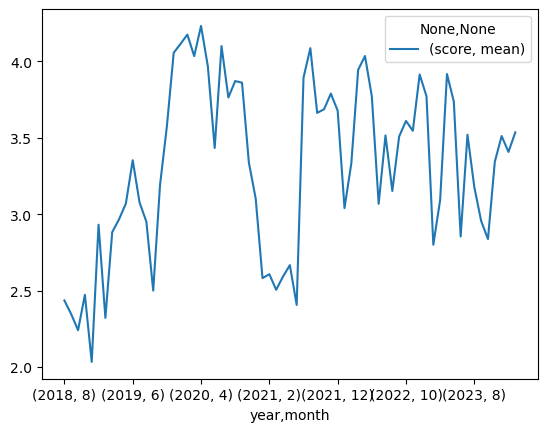

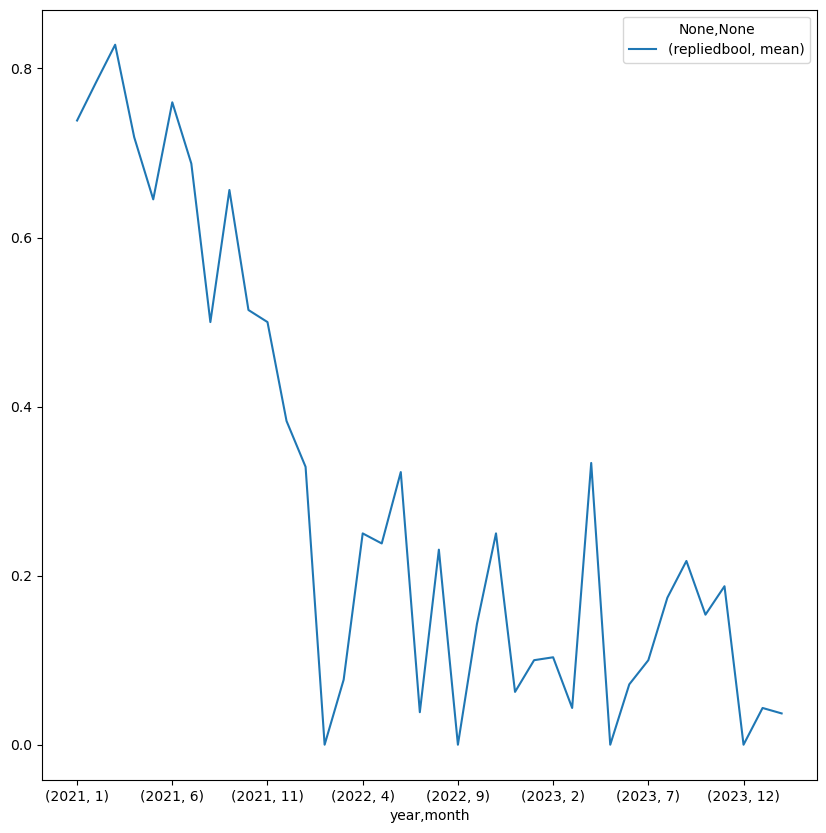

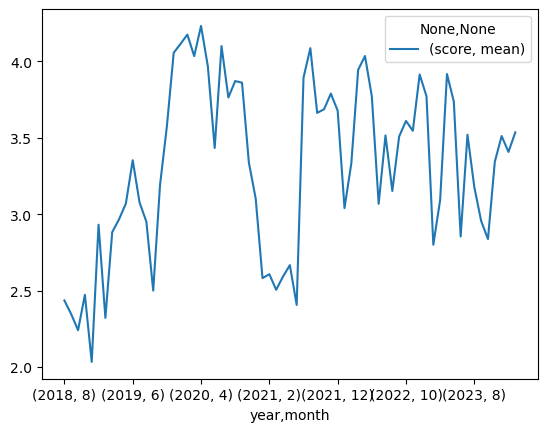

In [7]:
df_reviews.groupby(['score']).agg({'score':['count']})
df_reviews[0:200].groupby(['score']).agg({'score':['count']})
df_reviews.groupby(['year','month']).agg({'score':['mean']}).plot.line()
df_reviews[(df_reviews['score']<4 ) & 
           (df_reviews['year']>2020)].groupby(['year','month']).agg({'repliedbool':['mean']}).plot.line(figsize=(10,10))
df_reviews.groupby(['year','month']).agg({'score':['mean']}).plot.line()

df_reviews.groupby(['year','month']).agg({'score':['count','mean']})#.plot.line(figsize=(15, 15))

In [28]:
from openai import OpenAI
client = OpenAI()
#this is a helper function to call OpenAI API. 
#I am using gpt-3.5-turbo model for this analysis

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message.content



# response = client.chat.completions.create(
#   model="gpt-3.5-turbo-0125",
#   response_format={ "type": "json_object" },
#   messages=[
#     {"role": "system", "content": "You are a helpful assistant designed to output JSON."},
#     {"role": "user", "content": "Who won the world series in 2020?"}
#   ]
# )

# def get_completion(prompt, model="gpt-3.5"):
#     response = openai.completions.create(
#         engine=model,
#         prompt=prompt,
#         temperature=0.7,
#         max_tokens=100,
#         n=1,
#         stop=None,
#         log_level="info"
#     )
#     return response.choices[0].text.strip()


In [21]:
df_reviews.head()
col_name="userName"
col_review="content"
# let's take last 100 app reviews with rating below 4 stars
last_100_negative_reviews_df=df_reviews[df_reviews['score']<4][0:100]

In [22]:
last_100_negative_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,date,time,year,month,yearmonth,repliedbool
0,31adf045-7e28-4953-bc8b-dcbbd0bd2a5c,Ryan W,https://play-lh.googleusercontent.com/a-/ALV-U...,This company is a joke would not recommend you...,1,0,4.36.0,2024-02-24 11:41:22,None,NaT,4.36.0,2024-02-24,11:41:22,2024,2,20242,False
1,194fc48a-d96d-4c4f-9f68-bee406e2617e,Mattias Dreger,https://play-lh.googleusercontent.com/a-/ALV-U...,Login button doesn't work..,1,0,4.35.0,2024-02-23 21:56:01,None,NaT,4.35.0,2024-02-23,21:56:01,2024,2,20242,False
2,7f21ac05-b3e8-4408-b977-09e24abbee95,Tyler Raincock,https://play-lh.googleusercontent.com/a-/ALV-U...,Doesn't show my pending bills in my chequing a...,3,0,4.35.0,2024-02-23 21:14:59,None,NaT,4.35.0,2024-02-23,21:14:59,2024,2,20242,False
3,50d4531f-c38a-420a-9190-5adc0c84fd64,Jebus Crunkie,https://play-lh.googleusercontent.com/a-/ALV-U...,Add an option to set a nickname that will be u...,2,0,4.35.0,2024-02-22 11:04:48,None,NaT,4.35.0,2024-02-22,11:04:48,2024,2,20242,False
8,ef3337dc-cef4-4358-927c-674899f51ccc,Nick Leopardi,https://play-lh.googleusercontent.com/a/ACg8oc...,Option to cancel unaccepted e transfers unavai...,1,0,4.35.0,2024-02-21 10:40:27,None,NaT,4.35.0,2024-02-21,10:40:27,2024,2,20242,False


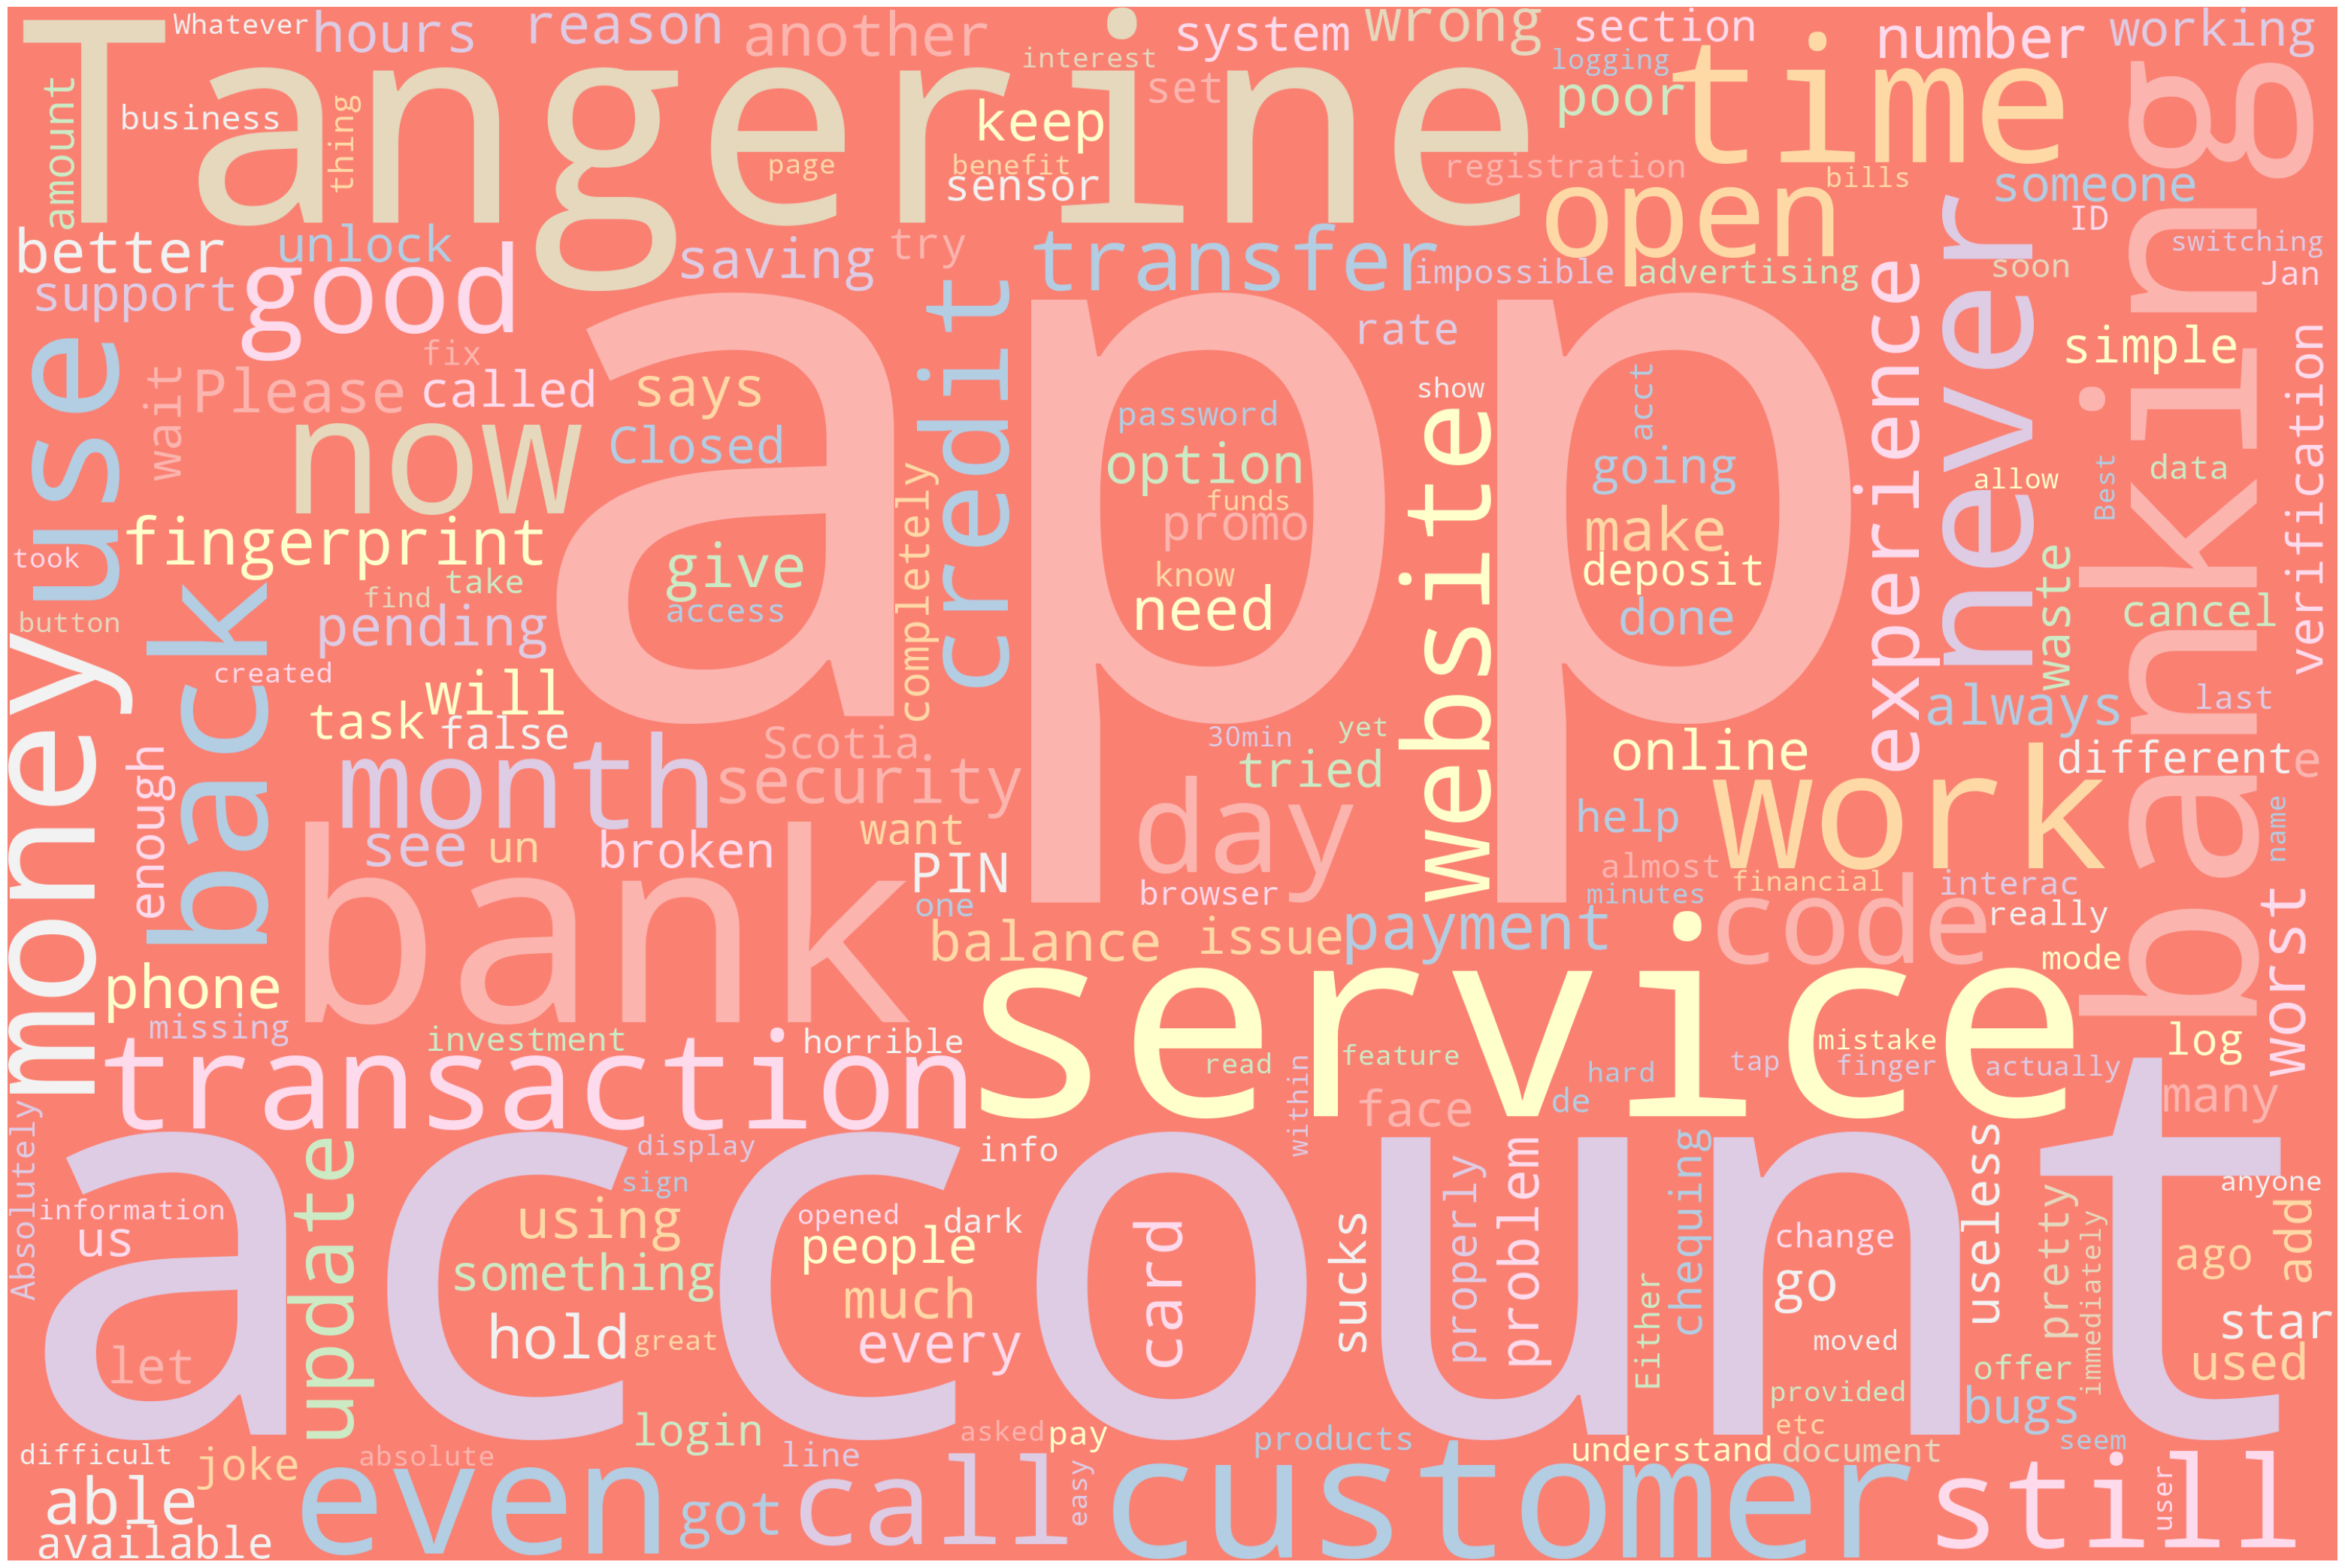

In [15]:

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");



product_stopwords = {}
#{"products","skill","skills","will","day","is",\
#"this","role","right","for","product","you","experience", "minimum", "digital","scotia"}


text = ' '.join(last_100_negative_reviews_df['content'].astype(str).values)

#text=' '.join([' '.join(ele) for ele in last_100_reviews_df['content']])

STOPWORDS=STOPWORDS.union(product_stopwords)

# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                      background_color='salmon', colormap='Pastel1', 
                      collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

In [16]:
# I want to detect the following using openai api
last_100_negative_reviews_df['summary']=''
last_100_negative_reviews_df['sentiment']=''
last_100_negative_reviews_df['emotions']=''
last_100_negative_reviews_df['anger']=''
last_100_negative_reviews_df['frustration']=''
last_100_negative_reviews_df['topics']=''
last_100_negative_reviews_df['review_response']=''


In [17]:
#Summarize the review using three keywords.
#Determine five topics that are being discussed in the review

In [29]:



for index, row in last_100_negative_reviews_df.iterrows():
    review=row['content']
    prompt = f"""\
Your task is to perform the following actions on the mobile app review delimited by triple backticks: 
1 - Summarize with 1 sentence.
2 - Determine the sentiment of the review 
3 - Identify a list of emotions in the review. Include no more than \
five items in the list. Format your answer as a list of \
lower-case words separated by commas.
4 - Identify if the writer of the app review expressing anger?
5 - Identify if the writer of the app review expressing frustration?
6 - Summarize the review using two words, but don't use the following keywords 'bank', 'banking', 'app',  \

Output a json object only that contains the following keys: \ 
summary, sentiment, emotions, anger as a boolean, frustration as boolean, topics.\
  Make sure output is a valid json format

Review: ```{review}```
"""
    
    response = get_completion(prompt)
    print(response)
    response_json = json.loads(response)
   
    #time.sleep(2)
    last_100_negative_reviews_df.at[index, 'summary']=response_json['summary']
    last_100_negative_reviews_df.at[index, 'sentiment']=response_json['sentiment']
    last_100_negative_reviews_df.at[index, 'emotions']=response_json['emotions']
    last_100_negative_reviews_df.at[index, 'anger']=response_json['anger']
    last_100_negative_reviews_df.at[index, 'frustration']=response_json['frustration']
    last_100_negative_reviews_df.at[index, 'topics']=response_json['topics']
    


{
    "summary": "Negative review comparing company to Koho.",
    "sentiment": "negative",
    "emotions": "disappointment, dissatisfaction",
    "anger": false,
    "frustration": true,
    "topics": "company comparison"
}


/var/folders/cq/40xd1c350qb48wl593nz7rjc0000gn/T/ipykernel_98531/934016234.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  last_100_negative_reviews_df.at[index, 'anger']=response_json['anger']
/var/folders/cq/40xd1c350qb48wl593nz7rjc0000gn/T/ipykernel_98531/934016234.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  last_100_negative_reviews_df.at[index, 'frustration']=response_json['frustration']


{
    "summary": "Login button issue.",
    "sentiment": "negative",
    "emotions": "frustration",
    "anger": false,
    "frustration": true,
    "topics": "login issue"
}
{
    "summary": "Lack of pending bill visibility on mobile.",
    "sentiment": "negative",
    "emotions": "frustration",
    "anger": false,
    "frustration": true,
    "topics": "pending bills visibility"
}
{
    "summary": "Request for nickname option and concern about deadnaming, overall positive experience.",
    "sentiment": "positive",
    "emotions": "concern, frustration, satisfaction",
    "anger": false,
    "frustration": true,
    "topics": "nickname, deadnaming"
}
{
    "summary": "Lack of option to cancel unaccepted e-transfers.",
    "sentiment": "negative",
    "emotions": ["disappointment"],
    "anger": false,
    "frustration": true,
    "topics": "cancel option"
}
{
    "summary": "Customer service issue with false charges.",
    "sentiment": "negative",
    "emotions": "frustration, disappo

In [30]:
last_100_negative_reviews_df.head()
last_100_negative_reviews_df.to_csv('~/Downloads/app_reviews_data_openai_last100_022824.csv')



In [31]:
#all_summaries = ' '.join([''.join(summary) for summary in last_100_reviews_df['summary']])
all_summaries = last_100_negative_reviews_df['topics'].values.tolist()

prompt = f"""\
you are a data analysist.\
You have received a lot of app reviews. 
Your task is to identify 20 most friequntly mentioned issues product team needs to fix \
from the mobile app review delimited by triple backticks\ 
You output should have one or two words to describe the issue and and the issue itself
```{all_summaries}```
"""
    
response = get_completion(prompt)
print(response)

1. Login issue
2. Customer service issue
3. Technical issues
4. Layout improvement
5. Difficulty navigation
6. Security issue
7. Inefficient experience
8. Poor service
9. Loading spinner
10. Functionality issues
11. Poor experience
12. Features removed
13. Limited availability
14. Cheque hold privacy
15. Outdated code
16. Face unlock update
17. Scam reimbursement
18. Bugs security
19. Payment setup
20. Security breach notifications


In [18]:
last_100_negative_reviews_df[last_100_negative_reviews_df['frustration']!=True].head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,summary,sentiment,emotions,anger,frustration,topics,review_response
15,fc5fbc6b-8d86-4721-aecf-6a01788d4268,Wayne Bruce,https://play-lh.googleusercontent.com/a-/AD_cM...,One of the worst banks ever. Hope you don't ha...,1,0,4.26.1,2023-05-16 16:20:07,None,NaT,A negative review of a bank app.,negative,"[anger, distrust, fear, disgust]",True,False,"[banking, customer service, trust, money, secu...",
17,e11a6c3b-5e22-4e40-8096-c4eaa14170ab,Dani D.A.N,https://play-lh.googleusercontent.com/a-/AD_cM...,poor,2,0,4.26.1,2023-05-16 00:57:53,None,NaT,The review is too short to summarize.,negative,[disappointment],False,False,[quality],
23,2b28dc65-e3a5-4f98-be27-94b0c649b1e7,tecca Glosser,https://play-lh.googleusercontent.com/a-/AD_cM...,Just terrible I've ever been,1,0,4.13.0,2023-05-14 13:45:44,None,NaT,The app is terrible.,negative,[disappointment],False,False,[app functionality],
31,18d72ec2-42bd-4053-a146-3a46b8d3735a,Remi Matlosz,https://play-lh.googleusercontent.com/a/AAcHTt...,Working directly with the Far-left Canadian co...,1,0,4.26.1,2023-05-09 18:29:28,None,NaT,The review expresses negative sentiment toward...,negative,"[anger, disgust]",True,False,"[financial fraud, ESG initiatives, debanking, ...",
81,4a632ca9-fb68-4134-891e-38eaa0ec4038,Joshua Elderton,https://play-lh.googleusercontent.com/a-/AD_cM...,horrible experience with this bank,1,0,4.25.0,2023-03-31 19:28:18,None,NaT,Negative review of a bank app.,negative,[disgust],True,False,"[bank, app]",


In [45]:
### Let's check what are the main topics about

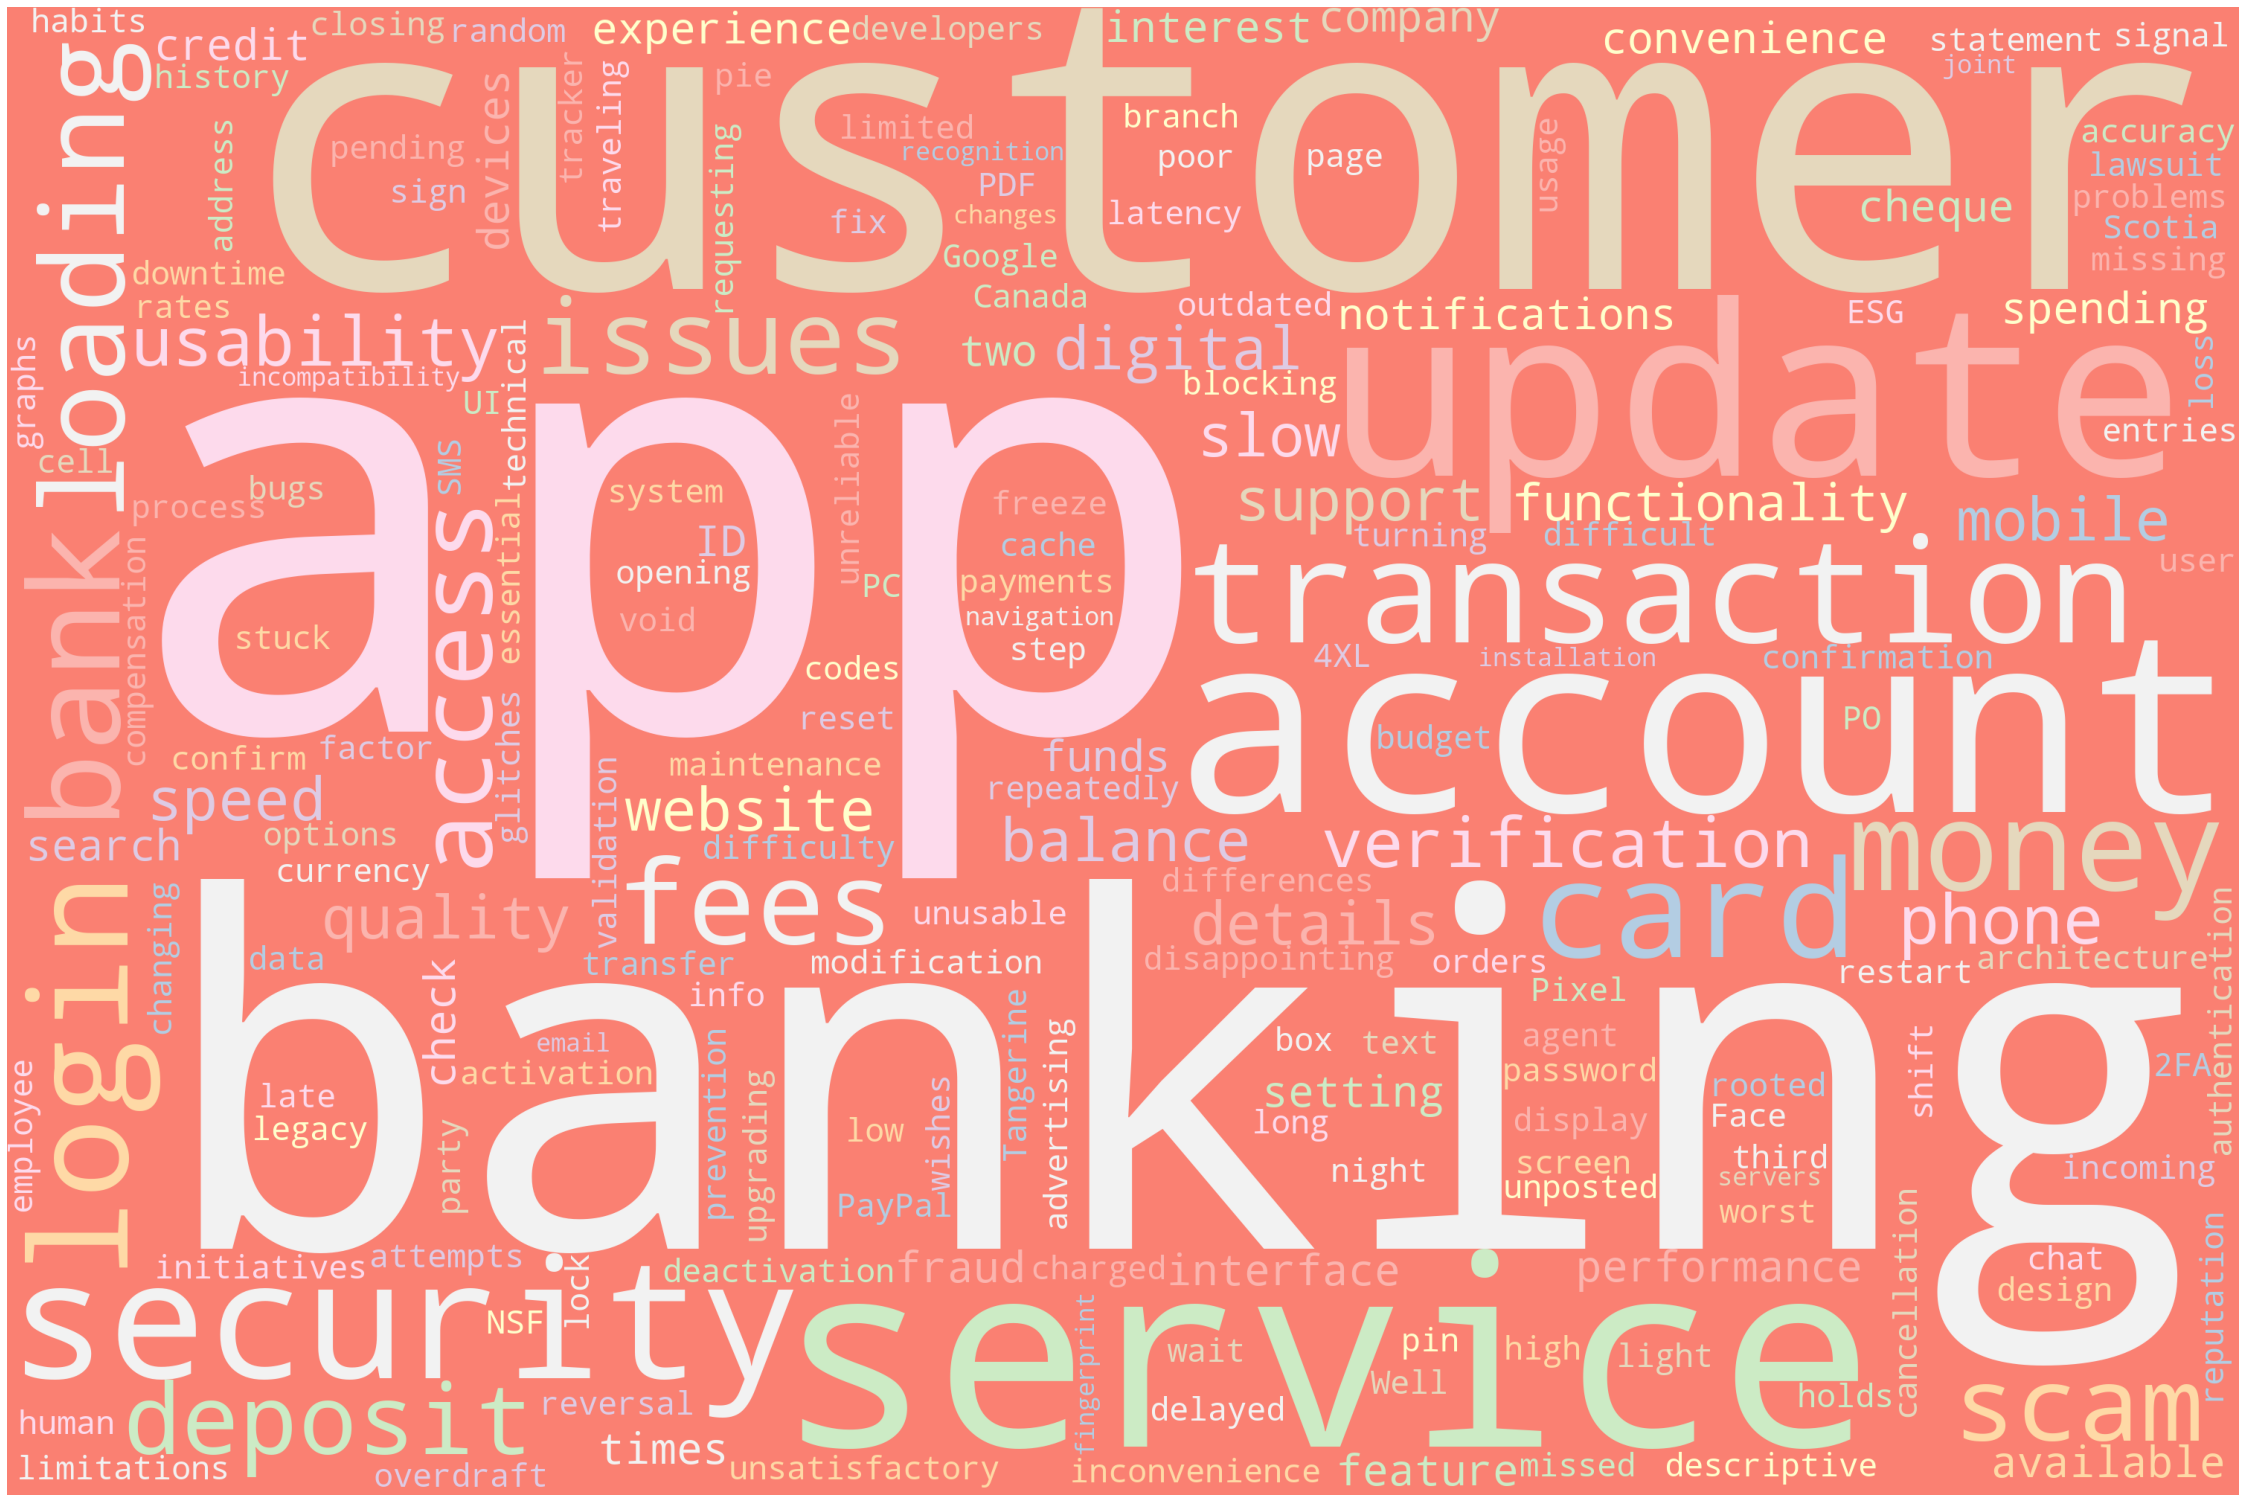

In [32]:
from collections import Counter
 
 
def freq(str):
 
    # break the string into list of words
    str_list = str.split()
 
    frequency = Counter(str_list)
 
    for word in frequency.most_common():
        print( word)
freq(text)

('to', 94)
('the', 74)
('I', 74)
('and', 58)
('my', 57)
('a', 54)
('is', 40)
('for', 40)
('not', 35)
('app', 31)
('in', 28)
('on', 27)
('it', 27)
('have', 25)
('of', 24)
('this', 23)
('you', 23)
('they', 22)
('account', 19)
('with', 17)
('are', 16)
('your', 15)
('that', 15)
('be', 15)
('do', 15)
('an', 14)
('service', 14)
('me', 14)
('Tangerine', 14)
('so', 14)
('but', 14)
('as', 13)
('from', 13)
('banking', 12)
('get', 12)
('has', 12)
('was', 12)
('use', 11)
('customer', 11)
('never', 11)
('been', 11)
('even', 11)
('The', 10)
('or', 10)
('since', 10)
('like', 9)
('no', 9)
("can't", 9)
('up', 9)
('bank', 9)
('out', 9)
('money', 9)
('This', 8)
('when', 8)
('their', 8)
("I'm", 8)
('credit', 8)
('more', 8)
('because', 8)
('by', 7)
('had', 7)
('over', 7)
('back', 7)
('now', 7)
("don't", 7)
('able', 7)
('App', 7)
('ever', 7)
('account.', 6)
('see', 6)
('will', 6)
('good', 6)
('other', 6)
('only', 6)
('got', 6)
('call', 6)
('another', 6)
('fingerprint', 6)
('how', 6)
('website', 6)
('securit

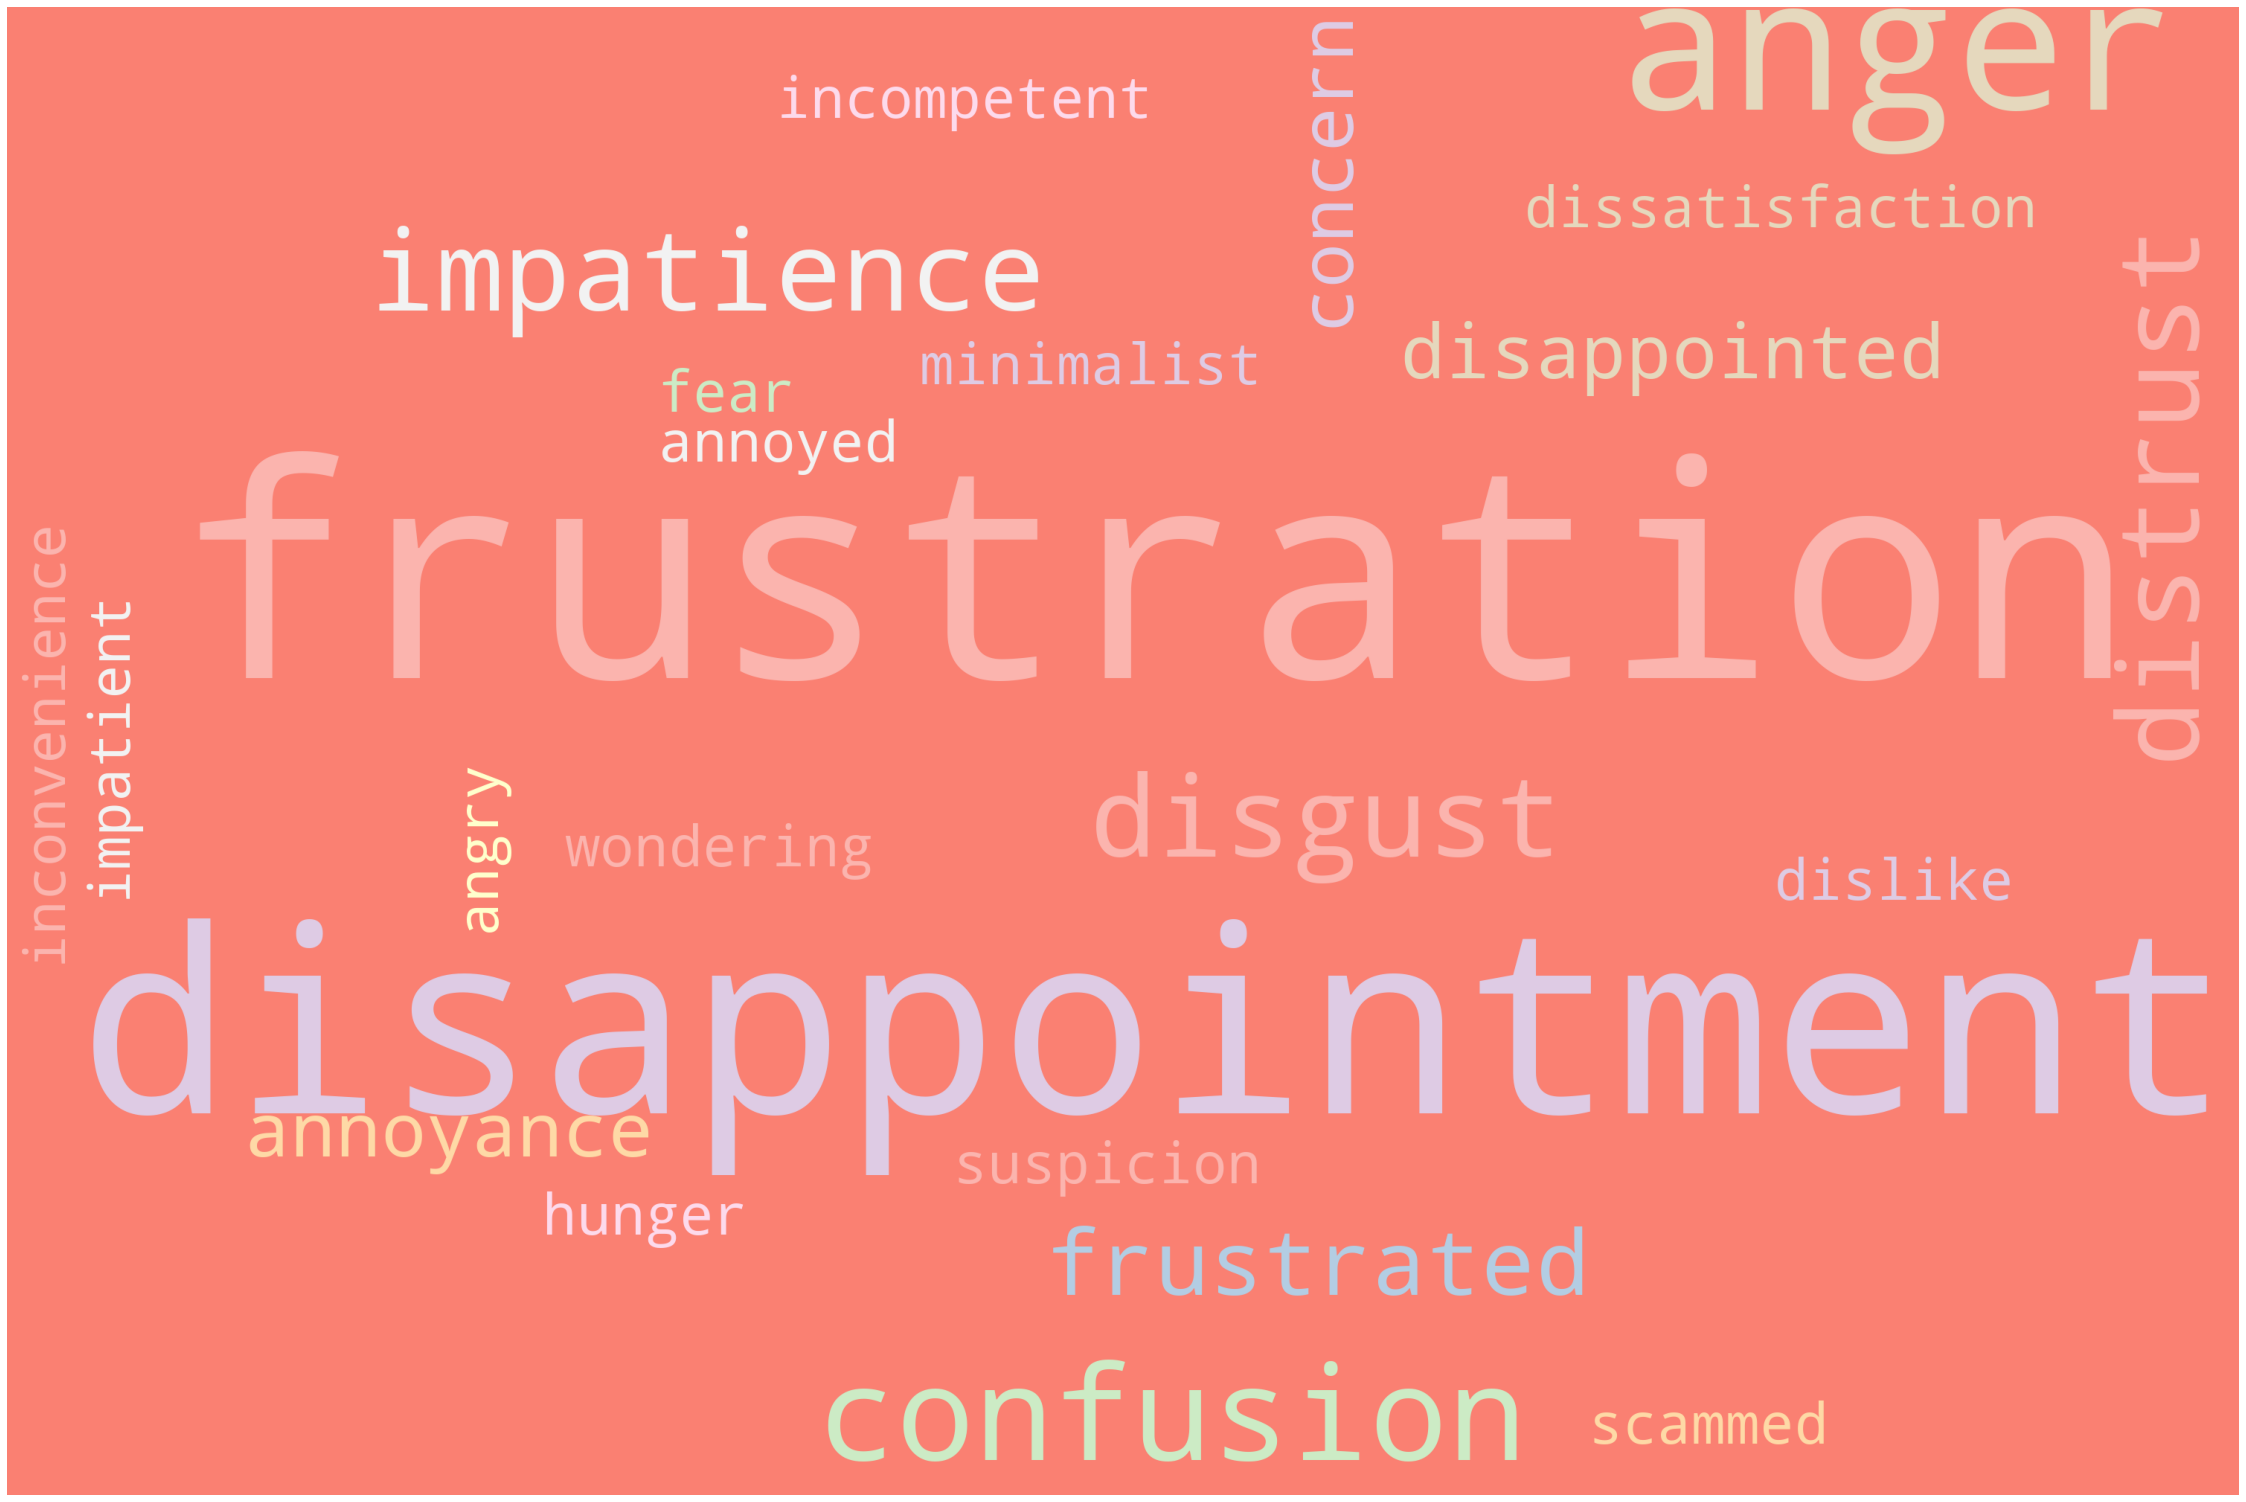

In [47]:

product_stopwords = {}
#{"products","scotiabank","skill","skills","will","day","is","this","role","right","for","product","you","experience", "minimum", "digital","scotia"}


# text = df_jan['content'].astype(str).values 

text=' '.join([' '.join(ele) for ele in last_100_negative_reviews_df['emotions']])

STOPWORDS=STOPWORDS.union(product_stopwords)

# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                      background_color='salmon', colormap='Pastel1', 
                      collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

In [40]:
# Create a training data based on reviews and responses. We took 5 examples 
responses_training_prompt=''
for index, row in df_reviews[df_reviews['repliedAt'].astype(str)!='NaT'][0:5].iterrows():
    prompt=f"""name:{row['userName']} review:{row['content']} response:{row['replyContent']}"""
    responses_training_prompt+=" "+prompt

    
print(responses_training_prompt)




 name:S. Crépeault review:Can't open this app anymore after the last update. Tried cleaning the cache. Another bug like last week. Can't open the app. response:Hi, we're really sorry about this. We request you to write to us on mobile.feedback@tangerine.ca with your Orange Key, as it will help us diagnose the root cause. You should be able to find your Orange Key by logging in to tangerine.ca > Side menu > Profile & Settings > General > Refer a Friend. name:Zack S review:Whenever I filter my transactions for February, it gives me March's transactions. When I filter for transactions in the current month (at the end of the month) it tells me I have no transactions for that month (which is false). This doesn't inspire confidence that it can't pull data up properly. Particularly when I'm seeing that the numbers in my account don't seem to be adding up. response:Hi Zack, we're sorry about this. Request you to write to us on mobile.feedback@tangerine.ca with your Orange Key, and we'll contin

In [48]:
freq(text)

Frequency of  inconvenience is : 1
Frequency of  frustration is : 52
Frequency of  anger is : 17
Frequency of  disappointment is : 38
Frequency of  hunger is : 1
Frequency of  annoyed is : 1
Frequency of  frustrated is : 3
Frequency of  impatient is : 1
Frequency of  confusion is : 7
Frequency of  distrust is : 5
Frequency of  fear is : 1
Frequency of  disgust is : 5
Frequency of  scammed is : 1
Frequency of  angry is : 1
Frequency of  impatience is : 5
Frequency of  annoyance is : 2
Frequency of  dissatisfaction is : 1
Frequency of  disappointed is : 2
Frequency of  minimalist is : 1
Frequency of  suspicion is : 1
Frequency of  concern is : 2
Frequency of  incompetent is : 1
Frequency of  dislike is : 1
Frequency of  wondering is : 1


In [41]:

    
last_100_negative_reviews_df.to_csv('~/Downloads/app_reviews_data_openai_last100_010623.csv')

{
  "response": "Hi Chris, we're sorry to hear about your experience. We understand how frustrating it can be when the app goes down unexpectedly. We assure you that our team is working hard to ensure that such incidents are minimized. If you could write to us on mobile.feedback@tangerine.ca with your Orange Key, we'll investigate the issue further and see how we can help. Thank you for your patience and understanding."
}
{
    "response": "Hi Okuurrrt, we apologize for the inconvenience caused. We understand how frustrating it can be when you can't access your digital card during maintenance. We'll make sure to pass on your feedback to our team. Thank you for bringing this to our attention."
}
{
  "response": "Hi Alex, thank you for your feedback. We understand the importance of having descriptive transaction details and we'll definitely take this into consideration for future updates. If you have any further concerns, please don't hesitate to reach out to us at mobile.feedback@tanger

{
  "response": "Hi Marcus, we're sorry to hear about your experience. We'd like to investigate this further. Could you please email us at mobile.feedback@tangerine.ca with your Orange Key and more details about the situation? Thank you."
}
{
  "response": "Hi Cassen, we apologize for the inconvenience caused. Could you please write to us on mobile.feedback@tangerine.ca with your Orange Key? We'll investigate the issue and get back to you as soon as possible. Thank you for your patience."
}
{
  "response": "Hi Joshua, we're sorry to hear that you had a bad experience with our bank. Could you please provide us with more details on what went wrong? We would like to investigate and improve our services. You can email us at mobile.feedback@tangerine.ca. Thank you."
}
{
  "response": "Hi P, we're sorry to hear about your experience. We'd like to investigate this further. Could you please email us at mobile.feedback@tangerine.ca with your Orange Key and more details about the issue? Thank yo

RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID bf9fec340e790317fd3ccf573c69377b in your message.)

In [33]:
for review in last_100_negative_reviews_df[(last_100_negative_reviews_df['frustration']==True) & (last_100_negative_reviews_df['anger']==True)]['topics']:
    print(review)

customer service issue
promo code issue
login issue
misidentification, checks
security issue
['problems', 'search', 'reward categories', 'billing cycle', 'broken']
experience, investments
misleading claims
account opening
customer service, decline
cheque hold, privacy
customer service
long process, disappointing offer
poor service
lockout, reset password
face unlock, update
customer service
horrible experience
technical issues
error, government
account closure
denial, misleading


In [54]:
def create_link(reviewId):
    return f"""https://play.google.com/console/u/1/developers/5044239417772664106/app/4973306756359859026/user-feedback/review-details?reviewId={reviewId}&corpus=PUBLIC_REVIEWS"""
last_100_negative_reviews_df['reviews_link']= last_100_negative_reviews_df.apply(lambda x: create_link(x['reviewId']), axis=1)

2     https://play.google.com/console/u/1/developers...
6     https://play.google.com/console/u/1/developers...
10    https://play.google.com/console/u/1/developers...
14    https://play.google.com/console/u/1/developers...
15    https://play.google.com/console/u/1/developers...
Name: reviews_link, dtype: object

In [27]:
# import streamlit as st
# def make_clickable(url, name):
#     return st.markdown('<a href="{}" rel="noopener noreferrer" target="_blank">{}</a>'.format(url, name),unsafe_allow_html=True)

# last_100_reviews_df['reviews_link'] =last_100_reviews_df['reviews_link'].apply(lambda x: make_clickable(x, 'Google Console Link'))

In [55]:
last_100_negative_reviews_df.to_csv('~/Downloads/app_reviews_data_openai_last100_02052023.csv')
last_100_negative_reviews_df.head()


,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,...,month,repliedbool,summary,sentiment,emotions,anger,frustration,topics,review_response,reviews_link
2,2,09f6c653-13a0-438b-a68a-729f07d8bef5,Cori M,https://play-lh.googleusercontent.com/a-/ACB-R...,"The ""pending transactions"" for my credit card ...",2,0,NaN,2023-05-01 11:56:14,NaN,...,5,False,Pending transactions disappear upon login.,negative,[frustration],False,True,"[credit card, pending transactions, login]","Hello Cori, we apologize for the inconvenience...",https://play.google.com/console/u/1/developers...
6,6,ace86547-4b08-4902-b8a3-c6331b8da4f2,Jan-Adam Van Der Henne,https://play-lh.googleusercontent.com/a-/ACB-R...,the amount of devices supported by this app is...,2,0,20.48.0,2023-04-30 23:49:47,NaN,...,4,False,Request for app to be available on more devices.,negative,"[disappointment, hopefulness]",False,True,"[device support, app availability]","Hello Jan-Adam, thank you for your feedback. W...",https://play.google.com/console/u/1/developers...
10,10,46b21506-ab5d-4be0-b665-9990d7fe17a4,kevin Hord,https://play-lh.googleusercontent.com/a-/ACB-R...,"Just about as bad as my branch, terribly spotty.",2,0,20.48.0,2023-04-30 14:26:17,NaN,...,4,False,The app is terrible and spotty.,negative,[disappointment],False,True,"[app, performance]","Hello Kevin, we're sorry to hear that you had ...",https://play.google.com/console/u/1/developers...
14,14,ca0a1d57-10c2-4bf1-b49e-6a124b79287c,Melly Mel,https://play-lh.googleusercontent.com/a/AGNmyx...,could improve on the technical side that other...,1,0,20.48.0,2023-04-30 08:41:32,NaN,...,4,False,Reviewer suggests technical improvements and c...,negative,"[disappointment, frustration, indifference]",False,True,"[technical, online banking, mobile app, functi...","Hello Melly, thank you for your feedback. We a...",https://play.google.com/console/u/1/developers...
15,15,62583d51-7154-4274-9966-b162f904e269,Alex Pike,https://play-lh.googleusercontent.com/a-/ACB-R...,So the app updated yesterday and now the app d...,3,0,20.49.1,2023-04-29 23:32:14,NaN,...,4,False,App update causing startup issue,negative,"[frustration, confusion]",False,True,"[app update, startup issue, bug fix, Scotia sy...","Hello Alex, we apologize for the inconvenience...",https://play.google.com/console/u/1/developers...
